Description:  This script produces Figure 9 (time-height plots of (i) VHF source density, and (ii) Flash initiation density)

In [452]:
import glob
import os
import warnings
from datetime import datetime

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import netCDF4 as ncdf
import numpy as np
import pandas as pd
import pyart
import xarray as xr

from lmatools.vis.multiples_nc import centers_to_edges
from may19_2013_obs_analysis.lma_parsing import ceil, sec2time, bbox_lma_data 

xr.set_options(display_style="html")

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [453]:
# subset flash source density and initiation dataset and limit region within bounding box of EC storm

source_dir = os.path.expanduser("../data/processed/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))

# spatial filtering of data for lma source density and flash initiations
# this is to ensure that we are confined to EC storm at all times for analysis purposes
datasets_den = []
datasets_ini = []
ll_lon = []
ul_lon = []
ll_lat = []
ul_lat = []

for i in range(len(ncnames_ini)):

    fden = ncnames_den[i]
    fini = ncnames_ini[i]

    data_den = xr.open_dataset(fden)
    data_ini = xr.open_dataset(fini)

    data_den = data_den.assign_coords(
        alt=data_den.altitude,
        lat=data_den.latitude,
        lon=data_den.longitude,
        ntimes=data_den.time,
    )

    data_ini = data_ini.assign_coords(
        alt=data_ini.altitude,
        lat=data_ini.latitude,
        lon=data_ini.longitude,
        ntimes=data_ini.time,
    )

    # using time string in names of density files as threshold to obtain the correct bounding limits
    # of Edmond-Carney storm. We could have used fini as well since both files contain same time strings.

    parts = fden.split("/")

    ll_lon, ul_lon, ll_lat, ul_lat = bbox_lma_data(int(parts[-1].split("_")[2]))

    # Applying bounding box limits to source density and flahs initiation datasets
    # to avoid counting data from regions outside the periphery of EC storm.

    source_data = data_den["lma_source"].where(
        (data_den.longitude > ll_lon)
        & (data_den.longitude < ul_lon)
        & (data_den.latitude > ll_lat)
        & (data_den.latitude < ul_lat)
    )

    time_height_source = source_data[:, :, :, :].sum(dim=["lat", "lon"]).T
    datasets_den.append(time_height_source)

    # Similarly, apply bounding box limits to flash initiation data
    initiation_data = data_ini["flash_initiation"].where(
        (data_ini.longitude > ll_lon)
        & (data_ini.longitude < ul_lon)
        & (data_ini.latitude > ll_lat)
        & (data_ini.latitude < ul_lat)
    )

    time_height_initiation = initiation_data[:, :, :, :].sum(dim=["lat", "lon"]).T
    datasets_ini.append(time_height_initiation)

    del data_den, data_ini

In [454]:
# load filtered CG data (CGs with peak current magnitude less than
# 15 kA and outside EC storm territory have been removed )
file  = '../data/interim/filtered_NLDN_15kA_only_within_EC_storm_for_pandas.txt'
cg_data = pd.read_csv(file, sep=",")

pos_cg = cg_data[cg_data["Power"] > 15]
neg_cg = cg_data[cg_data["Power"] < -15]

In [461]:
# pandas series cdf and pdf plot 
# code inspired from this link: https://stackoverflow.com/a/54317197/12538451

# Get the frequency, PDF and CDF for each value in the series

pos_cg.index = pd.to_datetime(pos_cg['datetime'])
pos_cg.drop('datetime',axis=1,inplace=True)

neg_cg.index = pd.to_datetime(neg_cg['datetime'])
neg_cg.drop('datetime',axis=1,inplace=True)

# Frequency
pos = pos_cg.index.value_counts().sort_index()
pos1 = pos.resample("Min").agg({'sum'})

neg = neg_cg.index.value_counts().sort_index()
neg1 = neg.resample("Min").agg({'sum'})

# create datetime stamps for missing timesteps and fill those indices with zero flash count
missing_idx = pd.date_range('2013-05-19 20:00:00',
                            '2013-05-19 22:30:00', freq='min')
pos1 = pos1.reindex(missing_idx, fill_value=0)
neg1 = neg1.reindex(missing_idx, fill_value=0)

# PDF
pos1['pdf'] = pos1['sum'] / sum(pos1['sum'])

neg1['pdf'] = neg1['sum'] / sum(neg1['sum'])


# CDF
pos1['cdf'] = pos1['pdf'].cumsum()
pos1 = pos1.reset_index()
pos1

neg1['cdf'] = neg1['pdf'].cumsum()
neg1 = neg1.reset_index()
neg1

,index,sum,pdf,cdf
0,2013-05-19 20:00:00,0,0.000000,0.000000
1,2013-05-19 20:01:00,0,0.000000,0.000000
2,2013-05-19 20:02:00,0,0.000000,0.000000
3,2013-05-19 20:03:00,0,0.000000,0.000000
4,2013-05-19 20:04:00,0,0.000000,0.000000
...,...,...,...,...
146,2013-05-19 22:26:00,1,0.006173,0.981481
147,2013-05-19 22:27:00,0,0.000000,0.981481
148,2013-05-19 22:28:00,2,0.012346,0.993827
149,2013-05-19 22:29:00,1,0.006173,1.000000


In [462]:
cg_data.index = pd.to_datetime(cg_data['datetime'])
cg_data.drop('datetime',axis=1,inplace=True)

cg_data_total = cg_data.index.value_counts().sort_index()
cg_data_total = cg_data_total.resample("Min").agg({'sum'})

# create datetime stamps for missing timesteps and fill those indices with zero flash count
missing_idx = pd.date_range('2013-05-19 20:00:00',
                            '2013-05-19 22:30:00', freq='min')
cg_data_total = cg_data_total.reindex(missing_idx, fill_value=0)


In [463]:
# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])

lasso_data = lasso_data.rename(columns={'number':'sum'})

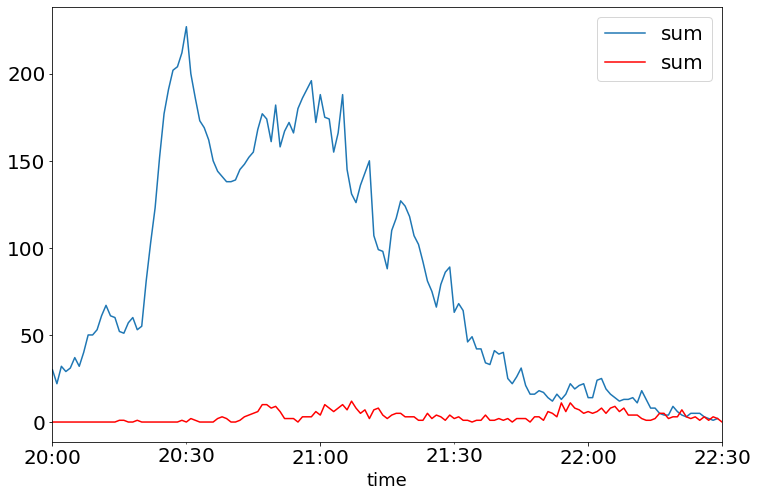

In [464]:
fig,ax = plt.subplots()
lasso_data.plot(ax=ax)
cg_data_total.plot(ax=ax,c='r')

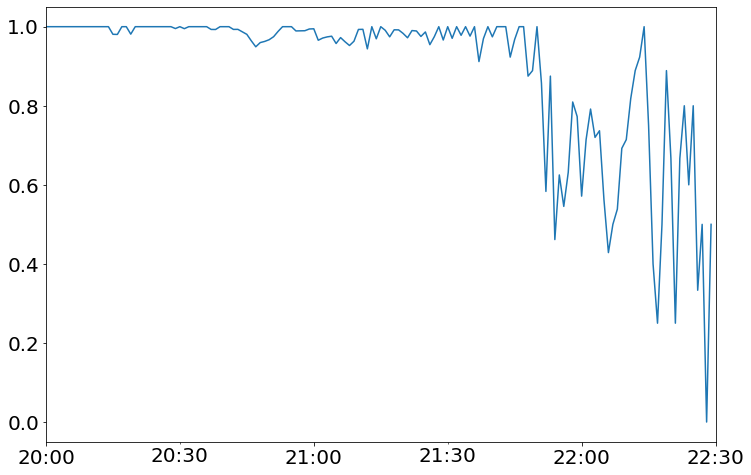

In [465]:
((lasso_data['sum'] - pos1.set_index('index')['sum'])/lasso_data['sum']).plot()

In [466]:
pos1.set_index('index',inplace=True)
neg1.set_index('index',inplace=True)

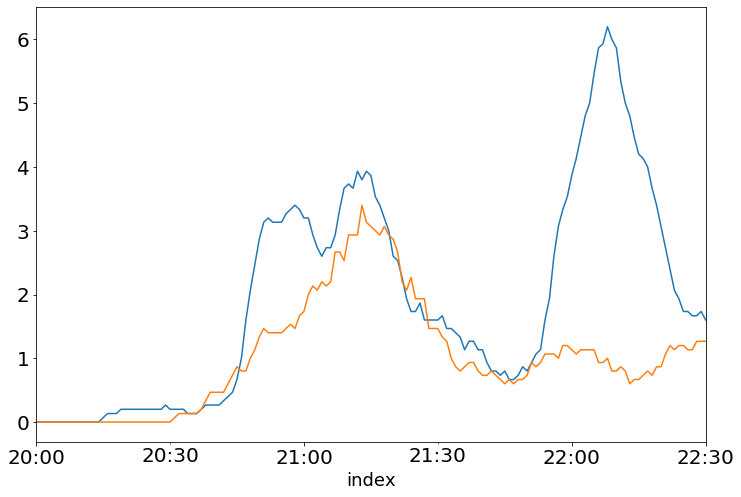

In [467]:
pos1.rolling('15T').mean()['sum'].plot()
neg1.rolling('15T').mean()['sum'].plot()

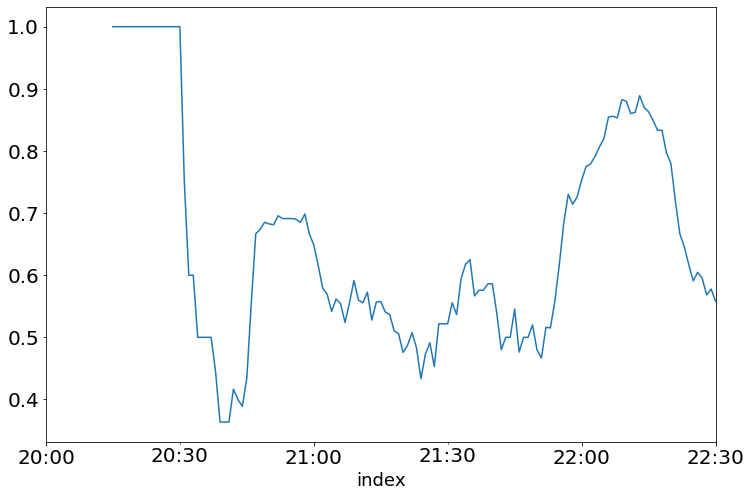

In [468]:
(pos1.rolling('15T').mean()['sum']/cg_data_total.rolling('15T').mean()['sum']).plot()

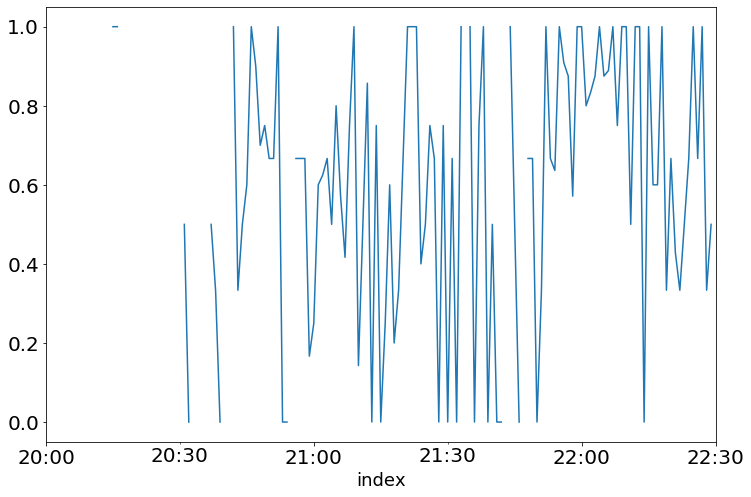

In [439]:
(pos1['sum']/cg_data_total['sum']).plot()

In [159]:
tt = pd.read_csv('/Users/ms/Desktop/mount/NLDN_data_2013_cases/nldn_33-38N,94-101W_May19-20,2013_dN4KG.txt',sep=r"\s*",header=None)

In [160]:
ttt = tt[tt[1] >= '20:00:00']
ttt1 = ttt[ttt[1] <= '22:30:00']

In [215]:
neg_cg_hh = ttt1[(ttt1[4] < 0) & (ttt1[5] == 'G')]
neg_cg_hh.index = pd.to_datetime(neg_cg_hh[1])

pos_cg_hh = ttt1[(ttt1[4] > 0) & (ttt1[5] == 'G')]
pos_cg_hh.index = pd.to_datetime(pos_cg_hh[1])

In [216]:
neg_cg_hh1 = neg_cg_hh.index.value_counts().sort_index()
neg_cg_hh1 = neg_cg_hh1.resample("Min").agg({'sum'})

pos_cg_hh1 = pos_cg_hh.index.value_counts().sort_index()
pos_cg_hh1 = pos_cg_hh1.resample("Min").agg({'sum'})

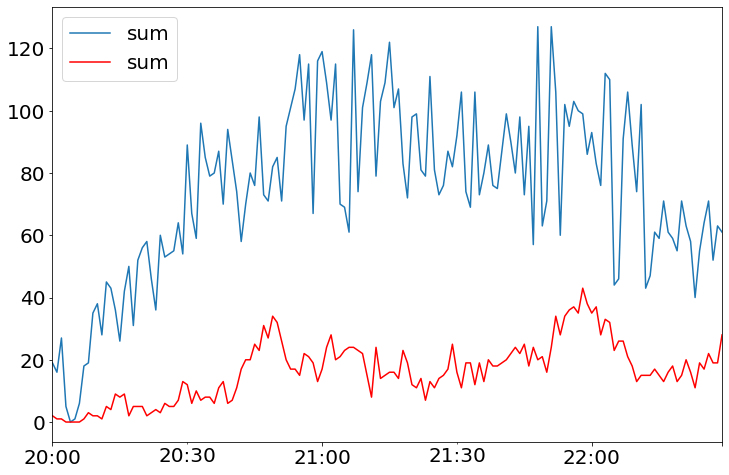

In [217]:
fig,ax = plt.subplots()
neg_cg_hh1.plot(ax=ax)
pos_cg_hh1.plot(c='r',ax=ax)

In [233]:
ttt1.index = pd.to_datetime(ttt1[1])
ttt1.index = ttt1.index.map(lambda t: t.replace(year=2013, month=5, day=19))

In [235]:
from may19_2013_obs_analysis.utils import extent_of_interest

In [236]:
extent_of_interest(ttt1.index[0])

(-98.1, -97.6, 35.35, 35.8)

In [238]:
import geopandas as gpd

In [269]:
dt_tmpstmps = pd.date_range(start='2013-05-19 20:00:00',end='2013-05-19 22:30:00',freq='10T')

In [242]:
hehe = gpd.GeoDataFrame(
        ttt1, geometry=gpd.points_from_xy(ttt1[2],ttt1[3]))
# gpd.points_from_xy(ttt1[2],ttt1[3])

In [386]:
total_cg = []
total_ic = []

pos_cg = []
pos_ic = []

neg_cg = []
neg_ic = []

for i in range(len(dt_tmpstmps)):
    tmp = hehe.loc[str(dt_tmpstmps[i]):str(dt_tmpstmps[i+1])]
    tmp1 = tmp[(tmp[4] < -15) | (tmp[4] > 15)]
    xmin,xmax,ymin,ymax = extent_of_interest(dt_tmpstmps[i])
    fin_cg = tmp1.cx[ymin:ymax,xmin:xmax]
    fin_ic = tmp.cx[ymin:ymax,xmin:xmax]
    
    cg = fin_cg[(fin_cg[5] == 'G')]
    ic = fin_ic[(fin_ic[5] == 'C')]
    
    poscg = cg[(cg[4] > 0)]
    negcg = cg[cg[4] < 0]
    
    posic = ic[(ic[4] > 0)]
    negic = ic[ic[4] < 0]
    
    cg_df = cg.index.value_counts().sort_index()
    ic_df = ic.index.value_counts().sort_index()
    
    poscg_df = poscg.index.value_counts().sort_index()
    posic_df = posic.index.value_counts().sort_index()
    
    negcg_df = negcg.index.value_counts().sort_index()
    negic_df = negic.index.value_counts().sort_index()
    
    total_cg.append(cg_df.resample("Min").agg({'sum'}))
    total_ic.append(ic_df.resample("Min").agg({'sum'}))
    
    pos_cg.append(poscg_df.resample("Min").agg({'sum'}))
    pos_ic.append(posic_df.resample("Min").agg({'sum'}))
    
    neg_cg.append(negcg_df.resample("Min").agg({'sum'}))
    neg_ic.append(negic_df.resample("Min").agg({'sum'}))

IndexError: index 16 is out of bounds for axis 0 with size 16

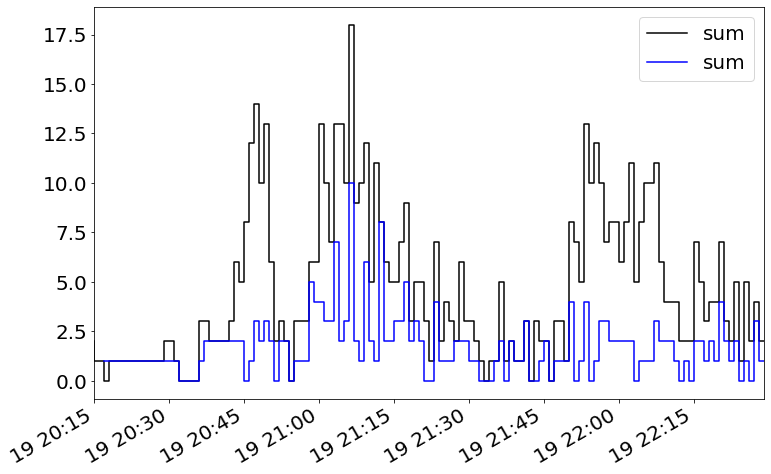

In [389]:
fig,ax = plt.subplots()
pd.concat(total_cg).plot(drawstyle='steps',c='k',ax=ax)
# pd.concat(pos_cg, ignore_index=True).plot(drawstyle='steps',c='r',ax=ax)
pd.concat(neg_cg).plot(drawstyle='steps',c='b',ax=ax)

In [399]:
missing_idx = pd.date_range('2013-05-19 20:00:00',
                            '2013-05-19 22:30:00', freq='min')
totalcg1 = pd.concat(total_cg).reindex(missing_idx, fill_value=0)
totalic1 = pd.concat(total_ic)

poscg1 = pd.concat(pos_cg).reindex(missing_idx, fill_value=0)
posic1 = pd.concat(pos_ic)

negcg1 = pd.concat(neg_cg).reindex(missing_idx, fill_value=0)
negic1 = pd.concat(neg_ic)

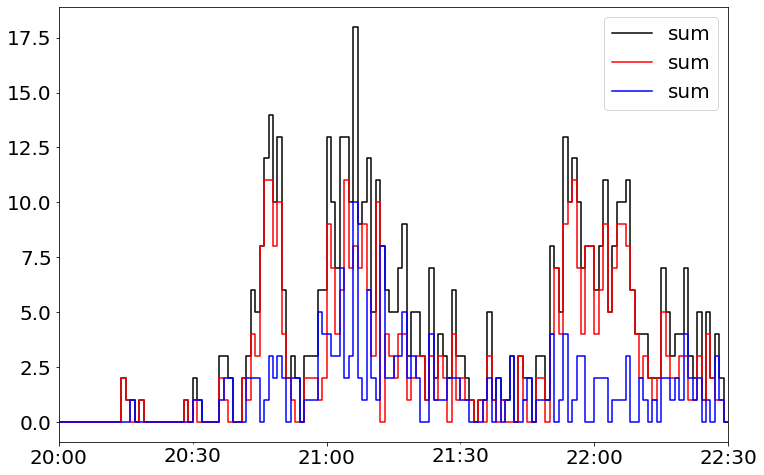

In [388]:
fig,ax = plt.subplots()
totalcg1.plot(drawstyle='steps',c='k',ax=ax)
poscg1.plot(drawstyle='steps',c='r',ax=ax)
negcg1.plot(drawstyle='steps',c='b',ax=ax)

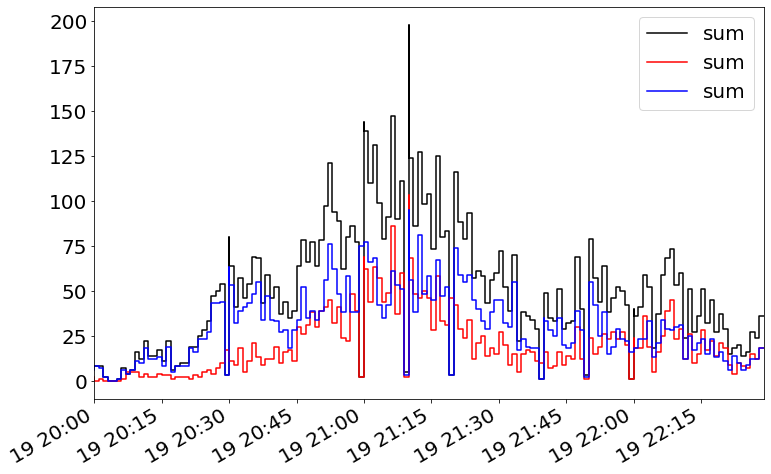

In [400]:
fig,ax = plt.subplots()
totalic1.plot(drawstyle='steps',c='k',ax=ax)
posic1.plot(drawstyle='steps',c='r',ax=ax)
negic1.plot(drawstyle='steps',c='b',ax=ax)

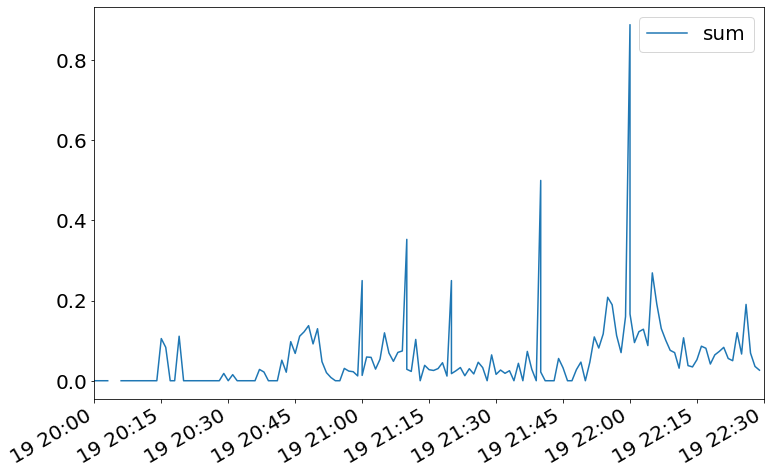

In [410]:
(poscg1/(totalic1 + totalcg1)).plot()

In [166]:
neg_cg_hh = ttt1[1].value_counts().sort_index()
# cg_data_total = cg_data_total.resample("Min").agg({'sum'})

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [141]:
uu = pd.DataFrame(yy)

In [148]:
uu = uu.rename(columns={1:'sum'})

In [154]:
uu.index = pd.to_datetime(uu.index)

In [158]:
uu.resample("Min").agg({'sum'})

,sum
,sum
2020-12-04 20:00:00,77
2020-12-04 20:01:00,82
2020-12-04 20:02:00,85
2020-12-04 20:03:00,19
2020-12-04 20:04:00,0
...,...
2020-12-04 22:25:00,288
2020-12-04 22:26:00,335
2020-12-04 22:27:00,240


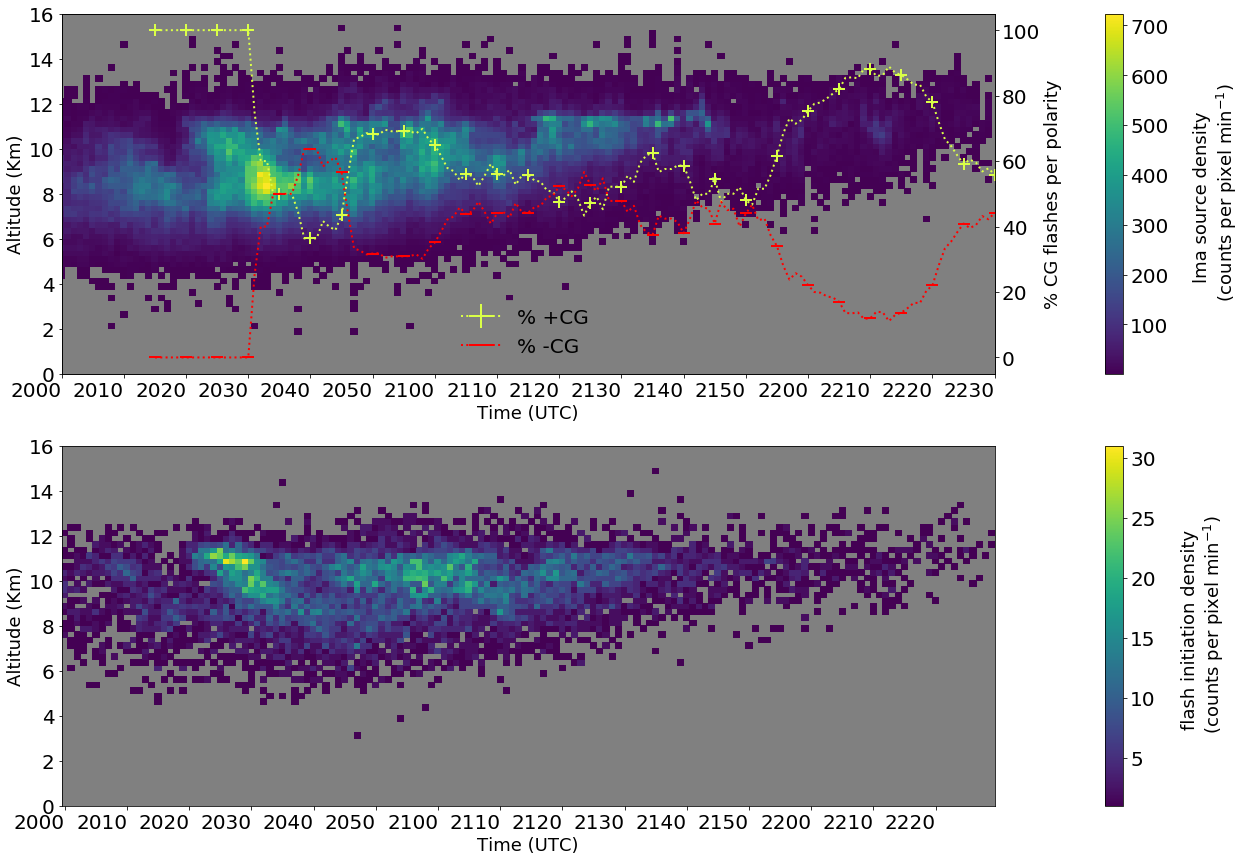

In [496]:
# Plot the filtered source density and flash initiation data
fig = plt.figure(figsize=(22, 25))
ax1 = fig.add_subplot(311)
combined_den = xr.concat(datasets_den, dim="ntimes")
combined_den = combined_den.where(combined_den.data > 0)
combined_den.data = combined_den.data
combined_den["alt"] = combined_den["alt"] / 1000

with pd.plotting.plot_params.use('x_compat', True):
    pl_den = combined_den.plot(ax=ax1, cmap="viridis", add_colorbar=False,)

# ax1.scatter(
#     pos_cg["datetime"],
#     np.ones_like(pos_cg["datetime"]),
#     marker="x",
#     c="#DAFF47",
#     s=50,
#     label="+CG flash",
# )
# ax1.scatter(
#     neg_cg["datetime"],
#     np.ones_like(neg_cg["datetime"]),
#     marker="^",
#     facecolors="none",
#     edgecolors="#C16092",
#     s=50,
#     label="-CG flash",
# )

axt = ax1.twinx()
with pd.plotting.plot_params.use('x_compat', True):
    (pos1.rolling('15T').mean()['sum']/cg_data_total.rolling('15T').mean()['sum'] * 100).plot(ax=axt,c='#DAFF47',
              marker='+',markevery=5,markersize=12,mew=2,
              linestyle=':',linewidth=2,label='% +CG ')
    
    (neg1.rolling('15T').mean()['sum']/cg_data_total.rolling('15T').mean()['sum'] * 100).plot(ax=axt,c='r',
              marker='_',markevery=5,markersize=12,mew=2,
              linestyle=':',linewidth=2,label='% -CG ')

#     pos1.plot(x='index',y='cdf',ax=axt,c='#DAFF47',
#               marker='+',markevery=5,markersize=12,mew=2,
#               linestyle=':',linewidth=2,label='+CG cdf')
#     neg1.plot(x='index',y='cdf',ax=axt,c='#C16092',
#               marker='_',markevery=5,markersize=12,mew=2,
#               linestyle=':',linewidth=2,label='-CG cdf')

ax1.set_facecolor("gray")
ax1.tick_params(axis='x',labelrotation=0)
axt.set_ylabel('% CG flashes per polarity')


ax2 = fig.add_subplot(312)
combined_ini = xr.concat(datasets_ini, dim="ntimes")
combined_ini = combined_ini.where(combined_ini.data > 0)
combined_ini.data = combined_ini.data
combined_ini["alt"] = combined_ini["alt"] / 1000
pl_ini = combined_ini.plot(ax=ax2, cmap="viridis", add_colorbar=False)
ax2.set_facecolor("gray")


ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
# plt.xticks(rotation=0)
ax1.set_ylabel("Altitude (Km)")
ax1.set_xlabel("Time (UTC)")
cbar1 = plt.colorbar(pl_den, pad=0.09, ax=ax1)
cbar1.set_label("lma source density \n (counts per pixel min$^{-1}$)", labelpad=25)

ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
# plt.xticks(rotation=0)
ax2.set_ylabel("Altitude (Km)")
ax2.set_xlabel("Time (UTC)")
cbar2 = plt.colorbar(pl_ini, pad=0.09, ax=ax2)
cbar2.set_label(
    "flash initiation density \n (counts per pixel min$^{-1}$)", labelpad=25
)
ax2.tick_params(axis='x',labelrotation=0)

# plt.tight_layout()
axt.legend(loc="lower center",facecolor='gray',edgecolor='gray')
# plt.savefig(os.path.expanduser(
#     '/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/timeheightsrcdensityinitiation.png'), bbox_inches='tight', dpi=300)

ax1.set_ylim(0,16)
ax2.set_ylim(0,16)
plt.show()

Trial using xarray and dask chunks

It works but is too slow

In [5]:
source_dir = os.path.expanduser("./data_files/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))
data_mega = xr.open_mfdataset(ncnames_den, concat_dim="ntimes", combine="nested")

dataset_mega = []
t = 0
for i in range(len(ncnames_den)):
    parts = ncnames_den[i]
    ll_lon, ul_lon, ll_lat, ul_lat = bbox_lma_data(
        int(parts.split("/")[-1].split("_")[2])
    )
    data = data_mega.isel(ntimes=slice(t, t + 10))
    dataset_mega.append(
        data.lma_source.where(
            (data.longitude > ll_lon)
            & (data.longitude < ul_lon)
            & (data.latitude > ll_lat)
            & (data.latitude < ul_lat)
        )
    )
    t += 10

ff = xr.concat(dataset_mega, dim="ntimes")

tt = ff.sum(dim=["lon", "lat"])
tt = tt.assign_coords(
    {
        "alt": data["altitude"].isel(ntimes=0).compute(),
        "ntimes": data_mega.time.compute(),
    }
)

tt.T.plot()

OSError: no files to open

In [ ]:
combined_ini = xr.concat(datasets_ini, dim="ntimes")
combined_ini = combined_ini.where(combined_ini.data > 0)

In [ ]:
combined_ini["alt"] = combined_ini["alt"] / 1000
pl_ini = combined_ini.plot(
    cmap="cubehelix_r", add_colorbar=True, norm=matplotlib.colors.LogNorm()
)

In [ ]:
combined_den = xr.concat(datasets_den, dim="ntimes")
combined_den = combined_den.where(combined_den > 0, drop=True)
# combined_den = combined_den.where(combined_den.data > 0)
fig = plt.figure(figsize=(20, 8))
combined_den.plot()

In [ ]:
combined_den.data = np.log(combined_den.data)
combined_den["alt"] = combined_den["alt"] / 1000
fig = plt.figure(figsize=(20, 8))
combined_den.plot()

In [ ]:
combined_ini = xr.concat(datasets_ini, dim="ntimes")
# combined_ini = combined_ini.where(combined_ini.data > 0)
combined_ini = combined_ini.where(combined_ini > 0, drop=True)
fig = plt.figure(figsize=(20, 8))
combined_ini.plot()

In [ ]:
combined_ini.data = np.log(combined_ini.data)
combined_ini["alt"] = combined_ini["alt"] / 1000
fig = plt.figure(figsize=(20, 8))
combined_ini.plot()

#### xarray map_blocks approach (unsuccessful so far)

In [4]:
source_dir = os.path.expanduser("./data_files/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))

# spatial filtering of data for lma source density and flash initiations
# this is to ensure that we are confined to EC storm at all times for analysis purposes
datasets_den = []
datasets_ini = []
ll_lon = []
ul_lon = []
ll_lat = []
ul_lat = []

data_den = xr.open_mfdataset(ncnames_den, concat_dim="ntimes", combine="nested")
data_den = data_den.set_coords(["latitude", "longitude", "altitude"])

final = data_den.chunk({"ntimes": 10})


dts = pd.date_range(start="2013-05-19 20:00:00", end="2013-05-19 22:29:00", freq="1T")
dtsnp = [x.to_datetime64().astype("datetime64[s]") for x in dts]

ll_lons = np.repeat(
    [
        -98.1,
        -98,
        -98,
        -97.9,
        -97.8,
        -97.75,
        -97.8,
        -97.7,
        -97.6,
        -97.6,
        -97.5,
        -97.4,
        -97.15,
        -97.25,
        -97,
    ],
    len(dts) / len(ncnames_den),
)
ul_lons = np.repeat(
    [
        -97.6,
        -97.3,
        -97.3,
        -97.2,
        -97.1,
        -97.1,
        -97,
        -96.8,
        -96.8,
        -96.8,
        -96.6,
        -96.6,
        -96.6,
        -96.75,
        -96.5,
    ],
    len(dts) / len(ncnames_den),
)
ll_lats = np.repeat(
    [
        35.35,
        35.35,
        35.35,
        35.4,
        35.4,
        35.45,
        35.4,
        35.5,
        35.5,
        35.5,
        35.5,
        35.55,
        35.62,
        35.63,
        35.62,
    ],
    len(dts) / 10,
)
ul_lats = np.repeat(
    [35.8, 35.8, 35.8, 35.9, 36, 36, 36, 36, 36, 36.1, 36.2, 36.1, 36.1, 36.1, 36.1],
    len(dts) / 10,
)

tt = zip(ll_lons, ul_lons, ll_lats, ul_lats)
tt = list(tt)

limits = dict()
for i in range(len(dts)):
    limits[dtsnp[i]] = tt[i]


def get_lma_data(lma_source: xr.DataArray, limits):
    t = lma_source.time.values.astype("datetime64[s]")
    ll_lon, ul_lon, ll_lat, ul_lat = limits[t]
    data = lma_source.where(
        (lma_source.longitude > ll_lon)
        & (lma_source.longitude < ul_lon)
        & (lma_source.latitude > ll_lat)
        & (lma_source.latitude < ul_lat)
    )
    return data.sum(dim=["lon", "lat"])


mapped = lma_source.chunk({"ntimes": 1}).map_blocks(get_lma_data, args=[limits])